In [19]:
#Program by : Albert C. Pamonag, M.Eng

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

In [20]:
def reinArea(db):
    output = (math.pi/4)*math.pow(db,2)
    return output

def modularRatio(ei,ebase):
    output = ei/ebase
    return output

def inertiaRec(b,h):
    output = (1/12)*b*math.pow(h,3)
    return output

def intertiaTransfer(area,d):
    output = area*math.pow(d,2)
    return output

def modulasRupture(fc):
    output = 0.62*math.sqrt(fc)
    return output

def flexuralCapacity(f,Icr,c):
    output = (f*Icr)/c
    return output

def strain(f,E):
    output = f/E 
    return output

def quadricEquation(a,b,c):
    discriminant = b * b - 4 * a * c;

    ##condition for real and different roots
    if discriminant > 0:
        root1 = (-b + math.sqrt(discriminant)) / (2 * a);
        root2 = (-b - math.sqrt(discriminant)) / (2 * a);
    elif discriminant == 0:
        root1 = root2 = -b / (2 * a);
    else:
        realPart = (-b / (2 * a));
        imagPart = (math.sqrt(-discriminant) / (2 * a));
    results = [root1,root2]
    return results

def varignonTherom(dataset_arr):
    total_a = 0 
    total_ab = 0 
    data_length = len(dataset_arr) 

    i = 0
    while i < data_length:
        total_ab += dataset_arr[i][0]*dataset_arr[i][1]
        total_a += dataset_arr[i][0]
        i = i + 1
    results = {
        "total" : total_a,
        "value" : total_ab/total_a
    }

    return results

In [21]:
b = 450 
h = 600
d = h - 50 
db = 29
n = 3

fc = 30 ##MPa 
fy = 415 ##MPa
e_o = 0.002
e_su = 0.006 
# // var elasticity_concrete = 30000 //MPa
elasticity_concrete = 4700*math.sqrt(fc) ##MPa
elasticity_steel = 2.0e5 ##MPa
Z = 150
fr = 3.25 ##MPa
e_sh = 3750 
fsu = 600 ##MPa

n_conc = modularRatio(elasticity_steel,elasticity_concrete)
area_gross = b*h
area_steel = n*reinArea(db)
epsilon_co = (2*fc)/elasticity_concrete
epsilon_s = fy/elasticity_steel
print("n = " + str(n_conc))
print("Area gross = " + str(area_gross))
print("Area steel = " + str(area_steel))
print("εco = " + str(epsilon_co))
print("εs = " + str(epsilon_s))

n = 7.76911429085342
Area gross = 270000
Area steel = 1981.5595662517621
εco = 0.002330734287256026
εs = 0.002075


### Important points in the M-𝜙 curve 
1. 𝜙 at cracking (just before cracking) | pointOne
2. 𝜙 at cracking (just after cracking) | pointTwo
3. 𝜙 at 0.45fc (elastic limit) | pointThree
4. 𝜙 when steel yields | pointFour
5. 𝜙 when concrete reaches εpeak | pointFive
6. 𝜙 when concrete reaches εultimate | pointSix

In [22]:
class MomentCurvature:
#     def __init__():
#         self.name = name
#         self.age = age
#     @staticmethod #here
    def pointOne(self):

        section_data = [
            [area_gross,h/2],
            [(n_conc-1)*area_steel,d],
        ]

        kd = varignonTherom(section_data)["value"]
        
        inertia_beam = inertiaRec(b,h)
        inertia_beam_transfer = intertiaTransfer(section_data[0][0],section_data[0][1] - kd)
   
        I_uncracked = (inertia_beam + inertia_beam_transfer) + intertiaTransfer(section_data[1][0],section_data[1][1] - kd)
        fr = modulasRupture(fc)
        Mcr = flexuralCapacity(fr,I_uncracked,h - kd)
        strain_value = strain(fr,elasticity_concrete)
        phi = strain_value/(h-kd)
        
        results = {
            "phi" : phi,
            "Mcr" : Mcr/1e6,
            "kd" : kd
        }
        return results
#     @staticmethod #here
    def pointTwo(self):
        
        section_data = [
            [b,1/2],
            [n_conc*area_steel,d],
        ]
        
        ## For Quadratic Equation Constants
       
        a_quad = section_data[0][0] - (section_data[0][0]*section_data[0][1]) 
        b_quad = section_data[1][0]
        c_quad = -1*section_data[1][0]*section_data[1][1]
        
        roots = quadricEquation(a_quad,b_quad,c_quad)
#         kd = Math.max(...roots)
        kd = np.max(roots)
        inertia_beam = (b*math.pow(kd,3))/3

        I_cracked = inertia_beam + intertiaTransfer(section_data[1][0],section_data[1][1] - kd)
        
        Mcr = self.pointOne()["Mcr"]*1e6
        
        fb = ((Mcr*(section_data[1][1] - kd))/ I_cracked)*n_conc     
        strain_value = strain(fb,elasticity_steel)
 
        phi = strain_value/(section_data[1][1]-kd)
        
        results = {
            "phi" : phi,
            "Mcr" : Mcr/1e6,
            "kd" : kd,
            "Icr" : I_cracked
        }
        
        return results

    def pointThree(self):
        
        kd = self.pointTwo()["kd"]
        I_cracked = self.pointTwo()["Icr"]
        strain = (0.45*fc)/elasticity_concrete
        phi = strain/kd

        Mcr = (0.45*fc*I_cracked)/(kd)
        results = {
            "phi" : phi,
            "Mcr" : Mcr/1e6,            
        }

        return results

    def pointFour(self):
        
        kd = self.pointTwo()["kd"]

        asfy_constant =  area_steel*fy 
        bfc_constant = b*fc  

        ##working on hognestad thereom
        def solver():

            c_final = 0
            kd_final = 0
            
            i = 0
            while i <= h: ##to adjust the increment soon..

                A = d - i
                constantA = epsilon_s/epsilon_co
                equationA = constantA*math.pow(i,2)/A   
                equationB = (constantA*math.pow(kd,2)) / math.pow(A,2)*(i/3)
                
                c = bfc_constant*(equationA - equationB)

                if c > asfy_constant:
                    c_final = c
                    kd_final = i
                    
                    break
                    
                i = i + 1
            return kd_final
        
        kd_final = solver()
        
        ##The maximum curvature at outermost compression fiber can now be calculated as
        e_cy = (epsilon_s/(d - kd_final))*kd_final

        phi = e_cy/kd_final

        ##For Moment capacity
        def yCB():
            A = ((2*e_cy)/(epsilon_co))*(math.pow(kd_final,3)/(3*kd_final))
            B = math.pow((e_cy/epsilon_co),2)*(math.pow(kd_final,4)/(4*math.pow(kd_final,2)))
            output_init = fc*(A-B)*b
            output = (output_init)/asfy_constant
            return output
        
        y = yCB()
        Mcr = asfy_constant*(d - kd_final + y)

        results = {
            "phi" : phi,
            "Mcr" : Mcr/1e6,            
        }
#         print('working')
        return results

    def pointFive(self):
        kd = (area_steel*fy)/((2/3)*fc*b)
        phi = epsilon_co/kd
        Mcr = area_steel*fy*(d -(3/8)*kd)

        results = {
            "phi" : phi,
            "Mcr" : Mcr/1e6,            
        }
        return results
    
    def pointSix(self):
        
        max_strain = 0.0038
        Yconstant = (epsilon_co/max_strain)
        
        C1 = (2/3)*fc*b*0.5
        C2 = 0.85*fc*b*0.5
        C3 = (1/2)*0.15*fc*b*0.5
        CTOTAL = C1 + C2 + C3 
        kd = (area_steel*fy)/CTOTAL
        Y1 = ((2/5)*Yconstant*kd)+(Yconstant*kd)
        Y2 = 0.5*Yconstant*kd
        Y3 = (2/3)*Yconstant*kd


        Y = Yconstant*kd
        compress_data = [
            [C1,Y1],
            [C2,Y2],
            [C3,Y3],
        ]
        y_distance = varignonTherom(compress_data)["value"]

        Mn = area_steel*fy*(d - y_distance)
        phi = max_strain/kd 
        results = {
            "phi" : phi,
            "Mcr" : Mn/1e6,            
        }
        return results

In [24]:
results = MomentCurvature()

phi_arr = [0,
    results.pointOne()["phi"],
    results.pointTwo()["phi"],
    results.pointThree()["phi"],
    results.pointFour()["phi"],
    results.pointFive()["phi"],
    results.pointSix()["phi"],
]
M_arr = [0,
    results.pointOne()["Mcr"],
    results.pointTwo()["Mcr"],
    results.pointThree()["Mcr"],
    results.pointFour()["Mcr"],
    results.pointFive()["Mcr"],
    results.pointSix()["Mcr"],    
] 

# print(phi_arr)
# print(M_arr)

MC_arr = [phi_arr, M_arr]
MC_df = pd.DataFrame(data = MC_arr,columns=["Point 0","Point 1","Point 2","Point 3","Point 4","Point 5","Point 6"])
MC_df

,Point 0,Point 1,Point 2,Point 3,Point 4,Point 5,Point 6
0,0,4.577708e-07,0.000001,0.000003,0.000006,0.000026,0.000050
1,0,1.048652e+02,104.865163,245.105787,403.209725,424.113681,418.131033


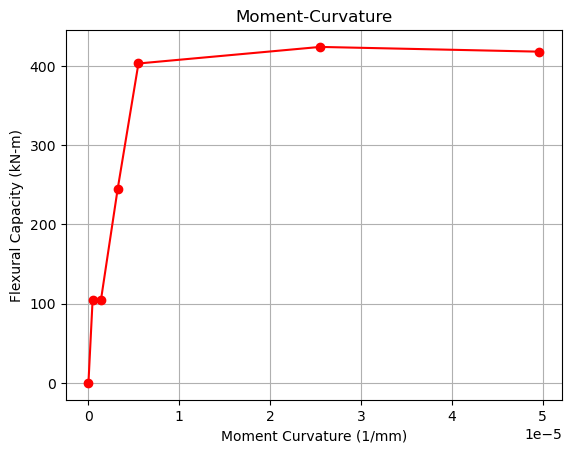

In [18]:
fig, ax = plt.subplots()
ax.plot(phi_arr, M_arr,marker='o',color='red')

ax.set(xlabel='Moment Curvature (1/mm)', ylabel="Flexural Capacity (kN-m)",
       title='Moment-Curvature')
ax.grid()

fig.savefig("Results.png")
plt.show()
